# Sartorius Segmentation - Detectron2 [Training]

# Detectron2
Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark

## Install Detectron2


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.9.1 True


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jyy2p02e
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jyy2p02e
  Resolved https://github.com/facebookresearch/detectron2.git to commit c470ca31d2b54d038b9e78f48d1d8e1a8debcc68
     |████████████████████████████████| 49 kB 889 kB/s 
     |████████████████████████████████| 74 kB 1.3 MB/s 
     |████████████████████████████████| 145 kB 2.7 MB/s 
     |████████████████████████████████| 130 kB 5.5 MB/s 
     |████████████████████████████████| 112 kB 5.5 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5728041 sha256=364b6937f875a897795ae82208e7fd71812cd136f44821724a99e4f68f0cb4c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-flw6tjft/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=46783c8a0

# importing libraries


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional



from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<_Logger detectron2 (DEBUG)>

# Loading Dataset

In [ ]:
Data_Resister_training="sartorius_Cell_train";
Data_Resister_valid="sartorius_Cell_valid";
from detectron2.data.datasets import register_coco_instances
dataDir=Path('../input/sartorius-cell-instance-segmentation/')

register_coco_instances(Data_Resister_training,{}, '../input/crossvalidationfold5/coco_cell_train_fold5.json', dataDir)
register_coco_instances(Data_Resister_valid,{},'../input/crossvalidationfold5/coco_cell_valid_fold5.json', dataDir)

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[11/12 05:39:00 d2.data.datasets.coco]: Loading ../input/crossvalidationfold5/coco_cell_train_fold5.json takes 2.10 seconds.
[11/12 05:39:00 d2.data.datasets.coco]: Loaded 485 images in COCO format from ../input/crossvalidationfold5/coco_cell_train_fold5.json
[11/12 05:39:02 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/crossvalidationfold5/coco_cell_valid_fold5.json


# Data Visualization
* It's also very easy to visualize prepared training dataset with detectron2.
* It provides Visualizer class, we can use it to draw an image with mask and bounding box as following.

(520, 704, 3)


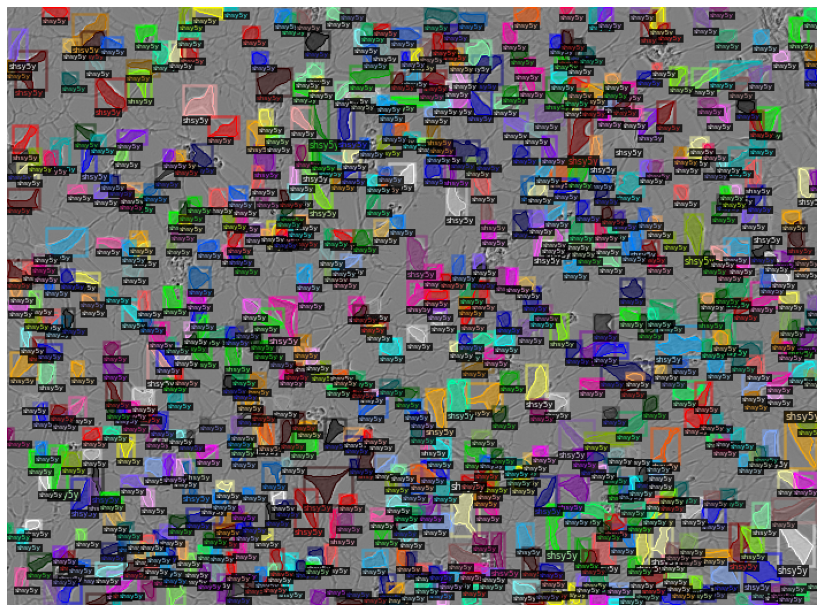

In [ ]:
fig, ax = plt.subplots(figsize =(18,11))
d=dataset_valid[2]
img = cv2.imread(d["file_name"])
print(img.shape)
v = Visualizer(img[:, :, ::-1],
                metadata=metadata,
                scale=1,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

# Data Augmentation
The dataset is transformed by changing the brighness and flipping the image with 50% probability...etc

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomSaturation(0.9, 1.1),
            T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

# Evaluator

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}

    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)



# Training

In [ ]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 64 is slower but more accurate (128 faster but less accurate)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005
#cfg.SOLVER.GAMMA = 0.1


cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 2000 #Maximum of iterations 1
cfg.SOLVER.STEPS = (500, 1000) #At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 250
cfg.SOLVER.CHECKPOINT_PERIOD=250

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[11/12 05:39:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Evaluator
* Famouns dataset's evaluator is already implemented in detectron2.
* For example, many kinds of AP (Average Precision) are calculted in COCOEvaluator.
* **COCOEvaluator calculates AP with IoU from 0.50 to 0.95**

In [ ]:
evaluator = COCOEvaluator(Data_Resister_valid, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="../input/detectron2cell/output/model_final.pth"
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
#cfg.INPUT.MASK_FORMAT='polygon'
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [11/12 06:28:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/12 06:28:32 d2.data.datasets.coco]: Loaded 121 images in COCO format from ../input/crossvalidationfold5/coco_cell_valid_fold5.json
[11/12 06:28:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/12 06:28:32 d2.data.common]: Serializing 121 elements to byte tensors and concatenating them all ...
[11/12 06:28:32 d2.data.common]: Serialized dataset takes 1.71 MiB
[11/12 06:28:32 d2.evaluation.evaluator]: Start inference on 121 batches
[11/12 06:28:34 d2.evaluation.evaluator]: Inference done 11/121. Dataloading: 0.0016 s/iter. Inference: 0.0714 s/iter. Eval: 0.0331 s/iter. Total: 0.1060 s/iter. ETA=0:00:11
[11/12 06:28:39 d2.evaluation.evaluator]: Inference done 48/121. Dataloading: 0.0033 s/iter. Infe

OrderedDict([('bbox',
              {'AP': 2.510270761318371,
               'AP50': 5.863402718186421,
               'AP75': 1.5783956465417903,
               'APs': 2.6094756845669713,
               'APm': 0.057553694181966805,
               'APl': 0.0,
               'AP-shsy5y': 7.530812283955113,
               'AP-cort': 0.0,
               'AP-astro': 0.0}),
             ('segm',
              {'AP': 2.812212967662449,
               'AP50': 6.2696553075182475,
               'AP75': 1.93048670026965,
               'APs': 2.8153612258595517,
               'APm': 2.145214521452145,
               'APl': 0.0,
               'AP-shsy5y': 8.436638902987347,
               'AP-cort': 0.0,
               'AP-astro': 0.0})])

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")


# Loss curve

In [ ]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

# Accuracy curve

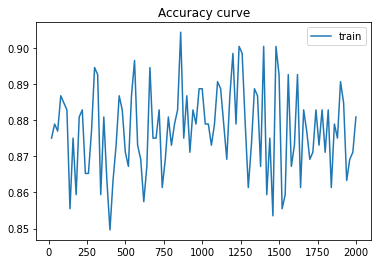

In [ ]:
# 1. Accuracy curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

# Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor = DefaultPredictor(cfg)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_valid, 4):
    i=i+1
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])